In [1]:
%pylab inline
from datetime import date
from datetime import datetime
import os
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Funciones para crear matrices de entrenaminto y pruebas

In [21]:
def train_X_Y(dias, precios, d_inicial,num_samples,num_features):    ##d_inicial : 0 a 2508
    ##dias: vector de dia de la semana para cada dia (L=1...V=5)
    ##precios: vector de pecios para cada dia
    ##d_inicial: Primer dia del entrenamiento (0 a 2508) es num_features-1 dias antes que el primer Y de entrenamiento 
    ##num_samples: Número de muestras para entrenar 
    ##num_features: Número de parametros de entrenamiento (1+ número de dias con que se predice el precio)
    
    
    
    num_dias = num_features-1
   
    dias = dias[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    dias = dias.reshape(len(dias),1)
    
    pr=precios[d_inicial:d_inicial+num_samples]
    
    for i in range(d_inicial+1,d_inicial+num_dias):
        m = precios[i:i+num_samples]
        pr =  np.column_stack((pr,m))
            
    X = np.column_stack((pr,dias))
             
    Y = precios[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    
    assert (X.shape == (num_samples, num_features))
    assert (Y.shape == (num_samples,))
    
    train = {"X": X,
                "Y": Y
            }
    
    return train



def test_X_Y(dias, precios, d_inicial,num_samples,num_features):
    test = train_X_Y(dias, precios, d_inicial,num_samples,num_features)
    
    return test

def errores(Y_expected,Y_predict):
    error_RMS= sqrt(mean_squared_error(Y_expected,Y_predict))
    error_MBE= mean(Y_expected-Y_predict)
    p_value = ks_2samp(Y_expected,Y_predict)[1]
                    
    error = {"RMS": error_RMS,
             "MBE": error_MBE,
             "P-Value": p_value
            }
    return error

def RMS(Y_prdct,Y):
    error = np.sqrt(sum((Y_prdct-Y)**2))/len(Y)
    return error

In [30]:
## Poblando datos

In [6]:
datos_csv = os.path.join( '.','COLCAP.csv')
datos_pd = pd.read_csv(datos_csv, sep = ',',
                encoding='latin-1', parse_dates =[0], infer_datetime_format= True)

In [7]:
a=datos_pd["Fecha (dd/mm/aaaa)"]

dias = []

for i in range(len(a)):
    d = a[i].weekday() + 1
    dias.append(d)
    
d = np.array(dias)

In [8]:
b = datos_pd["Valor COLCAP"]
b = np.array(b)
d
for i in range(len(b)):
    b[i] = b[i].replace(',',"")


p=np.array(b, dtype= np.float64)

In [9]:
## Prueba

In [10]:
#Definición de matrices de entreno
train=train_X_Y(d,p,1400,1000,6)
#scaler.fit(train['X'])
#train['X'] = scaler.transform(train['X'])

In [11]:
#Definición de matrices de prueba
test=test_X_Y(d,p,2450,30,6)
#test['X']= scaler.transform(test['X'])

In [12]:
#Entreno del sistema Adam
rg= None
e =10000
for i in range(10):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=(20,6), max_iter= 200, activation="relu",shuffle= False, solver= "adam", warm_start= False)
        r.fit(train["X"],train["Y"])
    
    error = errores(train['Y'],r.predict(train['X']))['RMS']
    
    
    if error<e:
        e=error
        rg=r
        print(e)

22.9382840776
21.2281963366
18.0120151564


In [13]:
print(rg.n_iter_)
print(e)

103
18.0120151564


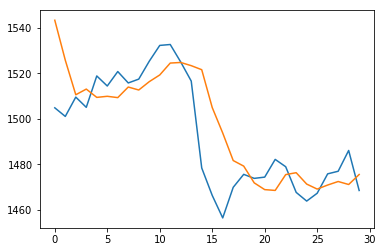

El Error RMS del entreno es: 18.0120151564
El Error MBE del entreno es: 0.274808282995
El P-Value del entreno es: 0.987500518257

El Error RMS de la prueba es: 16.7054398185
El Error MBE de la prueba es: -4.24294158485
El P-Value del entreno es: 0.537199539407


In [23]:
#### Grafica de predicción y real
plt.plot(test["Y"])
plt.plot(rg.predict(test["X"]))
error_train = errores(train['Y'],rg.predict(train['X']))
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS']))
print("El Error MBE del entreno es: " + str(error_train['MBE']))
print("El P-Value del entreno es: " + str(error_train['P-Value']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS']))
print("El Error MBE de la prueba es: " + str(error_test['MBE']))
print("El P-Value del entreno es: " + str(error_test['P-Value']))

In [63]:
#Prueba del modelo
rg.score(train["X"], train["Y"])

0.98830219636934269

In [64]:
rg.score(test["X"], test["Y"])

0.55886106766032984

In [25]:
#Entreno del sistema LBFGS
rg= None
e =10000
for i in range(10):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=(30,8), max_iter= 200, activation="relu",shuffle= False, solver= "lbfgs", warm_start=False)
        r.fit(train["X"],train["Y"])
    
    error = errores(train['Y'],r.predict(train['X']))['RMS']
    rg=r
    
    
    if error<e:
        e=error
        print(e)

11.9717031555
11.9464073782


In [26]:
print(rg.n_iter_)
print(e)

188
11.9464073782


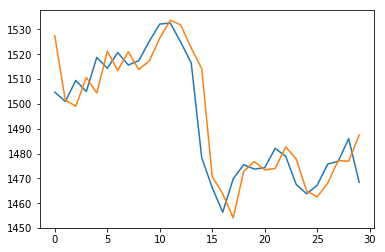

El Error RMS del entreno es: 12.0004473357
El Error MBE del entreno es: 0.080676944914
El P-Value del entreno es: 1.0

El Error RMS de la prueba es: 10.834348974
El Error MBE de la prueba es: -1.40584896516
El P-Value del entreno es: 0.996969237305


In [27]:
#Grafica de predicción y real
plt.plot(test["Y"])
plt.plot(rg.predict(test["X"]))
error_train = errores(train['Y'],rg.predict(train['X']))
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS']))
print("El Error MBE del entreno es: " + str(error_train['MBE']))
print("El P-Value del entreno es: " + str(error_train['P-Value']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS']))
print("El Error MBE de la prueba es: " + str(error_test['MBE']))
print("El P-Value del entreno es: " + str(error_test['P-Value']))

In [54]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='adam')
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(5):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
    c.append(clf.best_params_['hidden_layer_sizes'])
    
    print(c)

[(20, 10), (20, 6), (10, 5), (10, 6)]
[(20, 10), (20, 6), (10, 5), (10, 6), (10, 8)]
[(20, 10), (20, 6), (10, 5), (10, 6), (10, 8), (20, 6)]
[(20, 10), (20, 6), (10, 5), (10, 6), (10, 8), (20, 6), (10, 9)]
[(20, 10), (20, 6), (10, 5), (10, 6), (10, 8), (20, 6), (10, 9), (20, 5)]


In [65]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='lbfgs')
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(3):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
            
    c.append(clf.best_params_['hidden_layer_sizes'])
    
    print(c)

[(90, 8)]
[(90, 8), (40, 7)]
[(90, 8), (40, 7), (30, 9)]


In [ ]:
x = np.arange(1,len(conf)+1)
plt.bar(x,rep,tick_label=conf)
plt.plot()
plt.subplots_adjust(left=0.5, bottom=1, right=3, top=2)
plt.show()
plt.imsave("Results.jpg")